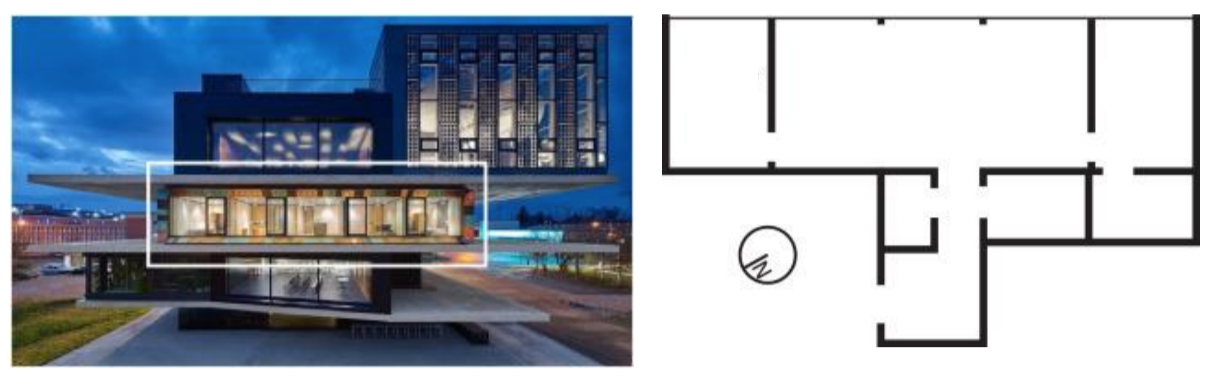

The is code is written as part of the NEST challenge hackathon. The goal of the challenge is to use log data from NEST to manage buildings in ways that are more sustainable and energy efficient. By investigating the relationships between a building's energy input, weather, indoor climate now and indoor climate in the future, we can find ways to minimize the energy needed to achieve a given indoor climate.

Reducing the number of sensors is an easy way to reduce the required energy input. As part of the analysis, we will investigate which sensors are necessary and which are not.

We are using TPOT autoML to find a regression model for predicting temperature. We use featurewiz to automate feature selection.

In [1]:
%%capture
!pip install tpot
!pip install featurewiz

In [2]:
# autoML
from tpot import TPOTRegressor
from sklearn.model_selection import train_test_split

# auto feature selection
from featurewiz import featurewiz

# handling data
import pandas as pd

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Imported featurewiz: advanced feature engg and selection library. Version=0.0.42
output = featurewiz(dataname, target, corr_limit=0.70,
                    verbose=2, sep=',', header=0, test_data='',
                    feature_engg='', category_encoders='')
Create new features via 'feature_engg' flag : ['interactions','groupby','target']
                                


In [3]:
#the source of the data
data_source = "https://raw.githubusercontent.com/WolframWilluhn/ENRGCLIM21_04_NEST/main/SolAce/solace_data.csv"

#the target of the prediction model
target = 'temp_office'

#columns in the original dataset to remove
drop_cols = ['temp_meeting', 'Unnamed: 0']


Read and format the data

In [4]:
data = pd.read_csv(data_source)

#drop certain columns
data = data.drop(columns=drop_cols)

data['time'] = pd.to_datetime(data['time'], yearfirst=True, infer_datetime_format=True)

print(data.time.dtype)
data.head()

datetime64[ns]


,time,blinds_height_F1,blinds_height_F2,blinds_height_F3,blinds_height_F4,cooling_power,heating_power,irrad,praes_meeting,praes_office,pv_active_power,setp_meeting,setp_office,temp_amb,temp_office,total_active_power,Y1_meeting,Y1_office
0,2019-07-01 00:00:00,0.0,0.0,0.0,0.0,1.18631,0.0,0.0,0.0,0.0,0.01,22.0,16.5,25.9,24.8,0.18711,100.0,100.0
1,2019-07-01 00:01:00,0.0,0.0,0.0,0.0,1.18630,0.0,0.0,0.0,0.0,0.01,22.0,16.5,25.9,24.8,0.18207,100.0,100.0
2,2019-07-01 00:02:00,0.0,0.0,0.0,0.0,1.17045,0.0,0.0,0.0,0.0,0.01,22.0,16.5,25.8,24.8,0.18900,100.0,100.0
3,2019-07-01 00:03:00,0.0,0.0,0.0,0.0,1.18467,0.0,0.0,0.0,0.0,0.01,22.0,16.5,25.8,24.8,0.18774,100.0,100.0
4,2019-07-01 00:04:00,0.0,0.0,0.0,0.0,1.19020,0.0,0.0,0.0,0.0,0.01,22.0,16.5,25.9,24.8,0.19404,100.0,100.0


In [5]:
#drop NA and NaN
data.iloc[:,1:] = data.iloc[:,1:].apply(pd.to_numeric, errors='coerce')
data = data.dropna()

#drop 'time' column due to further processing needs for TPOT
data = data.iloc[:,1:]

#sample_size
sample_size = 25000

#sample data to stay within featurewiz 100k dataframe size constraint
data = data.sample(sample_size, random_state=42)

print(len(data.index))
data.head()

25000


,blinds_height_F1,blinds_height_F2,blinds_height_F3,blinds_height_F4,cooling_power,heating_power,irrad,praes_meeting,praes_office,pv_active_power,setp_meeting,setp_office,temp_amb,temp_office,total_active_power,Y1_meeting,Y1_office
323025,0.0,100.0,100.0,100.00,0.000000,0.24439,0.0,0.0,0.0,0.01,21.0,21.0,13.4,21.4,0.17262,17.2549,36.8627
250077,0.0,0.0,0.0,0.00,0.000000,0.00000,97.0,0.0,0.0,-0.01,22.0,22.0,7.6,19.2,0.11529,0.0000,0.0000
30474,0.0,0.0,0.0,0.00,0.000000,0.00000,0.0,0.0,0.0,0.00,22.0,22.0,19.0,30.6,0.22176,0.0000,0.0000
34851,100.0,100.0,100.0,2.55,0.000000,0.00000,0.0,0.0,0.0,0.02,22.0,22.0,20.7,30.7,0.15624,0.0000,0.0000
432577,0.0,100.0,100.0,100.00,0.210151,0.00000,281.0,0.0,0.0,-0.08,21.0,21.0,13.5,20.7,0.09828,55.2941,12.5490


Select the model features. We use Featurewiz (an open-source python package) for automatically creating and selecting important features in the dataset that will create the best model with higher performance. Featurewiz uses the SULOV algorithm and Recursive XGBoost to reduce features to select the best features for the model. It also allows us to use advanced feature engineering strategies to create new features. 

Featurewiz uses the SULOV (Searching for Uncorrelated List of Variables) algorithm. The algorithm works in the following steps.


1.   First step: find all the pairs of highly correlated variables exceeding a correlation threshold (say absolute(0.8)).
2.   Second step: find their Mutual Information Score to the target variable. Mutual Information Score is a non-parametric scoring method. So it's suitable for all kinds of variables and target.
3.   Third step: take each pair of correlated variables, then knock off the one with the lower Mutual Information Score.
4. Final step: Collect the ones with the highest Information scores and least correlation with each other.

Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
Loading train data...
Shape of your Data Set loaded: (25000, 17)
Loading test data...
    Filename is an empty string or file not able to be loaded
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
    16 Predictors classified...
        No variables removed since no ID or low-information variables found in data set
GPU active on this device
    Running XGBoost using GPU parameters
Removing 0 columns from further processing since ID or low information variables
    After removing redundant variables from further processing, features left = 16
#### Single_Label Regression Feature Selection Started ####
Searching for highly correlated variables from 16 variables using SULOV method
#####  SULOV : Searching for Uncorrelated List Of Variables (takes time...) ############
There are no null valu

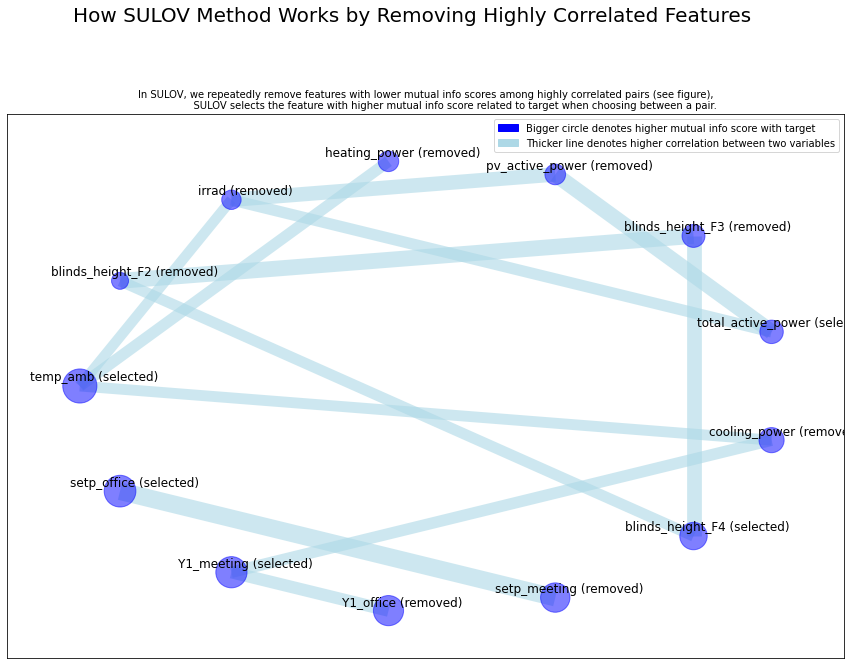

    Adding 0 categorical variables to reduced numeric variables  of 8
############## F E A T U R E   S E L E C T I O N  ####################
Current number of predictors = 8 
    Finding Important Features using Boosted Trees algorithm...
        using 8 variables...
        using 6 variables...
        using 4 variables...
        using 2 variables...
Selected 8 important features from your dataset
    Time taken (in seconds) = 6
Returning list of 8 important features and dataframe.


In [6]:
features, train = featurewiz(data, target, corr_limit=0.5, verbose=0, sep=",",header=0,test_data="", feature_engg="", category_encoders="")

In [7]:
print(features)

['blinds_height_F4', 'temp_amb', 'setp_office', 'Y1_meeting', 'blinds_height_F1', 'total_active_power', 'praes_office', 'praes_meeting']


In [8]:
data.features = data[features]
data.features.head()

,blinds_height_F4,temp_amb,setp_office,Y1_meeting,blinds_height_F1,total_active_power,praes_office,praes_meeting
323025,100.00,13.4,21.0,17.2549,0.0,0.17262,0.0,0.0
250077,0.00,7.6,22.0,0.0000,0.0,0.11529,0.0,0.0
30474,0.00,19.0,22.0,0.0000,0.0,0.22176,0.0,0.0
34851,2.55,20.7,22.0,0.0000,100.0,0.15624,0.0,0.0
432577,100.00,13.5,21.0,55.2941,0.0,0.09828,0.0,0.0


Select the prediction target

In [9]:
data.target = data[target]
data.target.head()

323025    21.4
250077    19.2
30474     30.6
34851     30.7
432577    20.7
Name: temp_office, dtype: float64

Run a model pipeline. Build and evaluate the model.

We use the TPOT (Tree-based Pipeline Optimization Tool) Python library for automated machine learning. TPOT uses a tree-based structure to represent a model pipeline for a predictive modeling problem, including data preparation and modeling algorithms, and model hyperparameters.

TPOT optimizes machine learning pipelines using genetic programming. It explores thousands of possible pipelines to find the best one for the data. Once TPOT is finished searching, it provides Pythons code for the best pipeline it found so we can tinker with the pipeline from there.

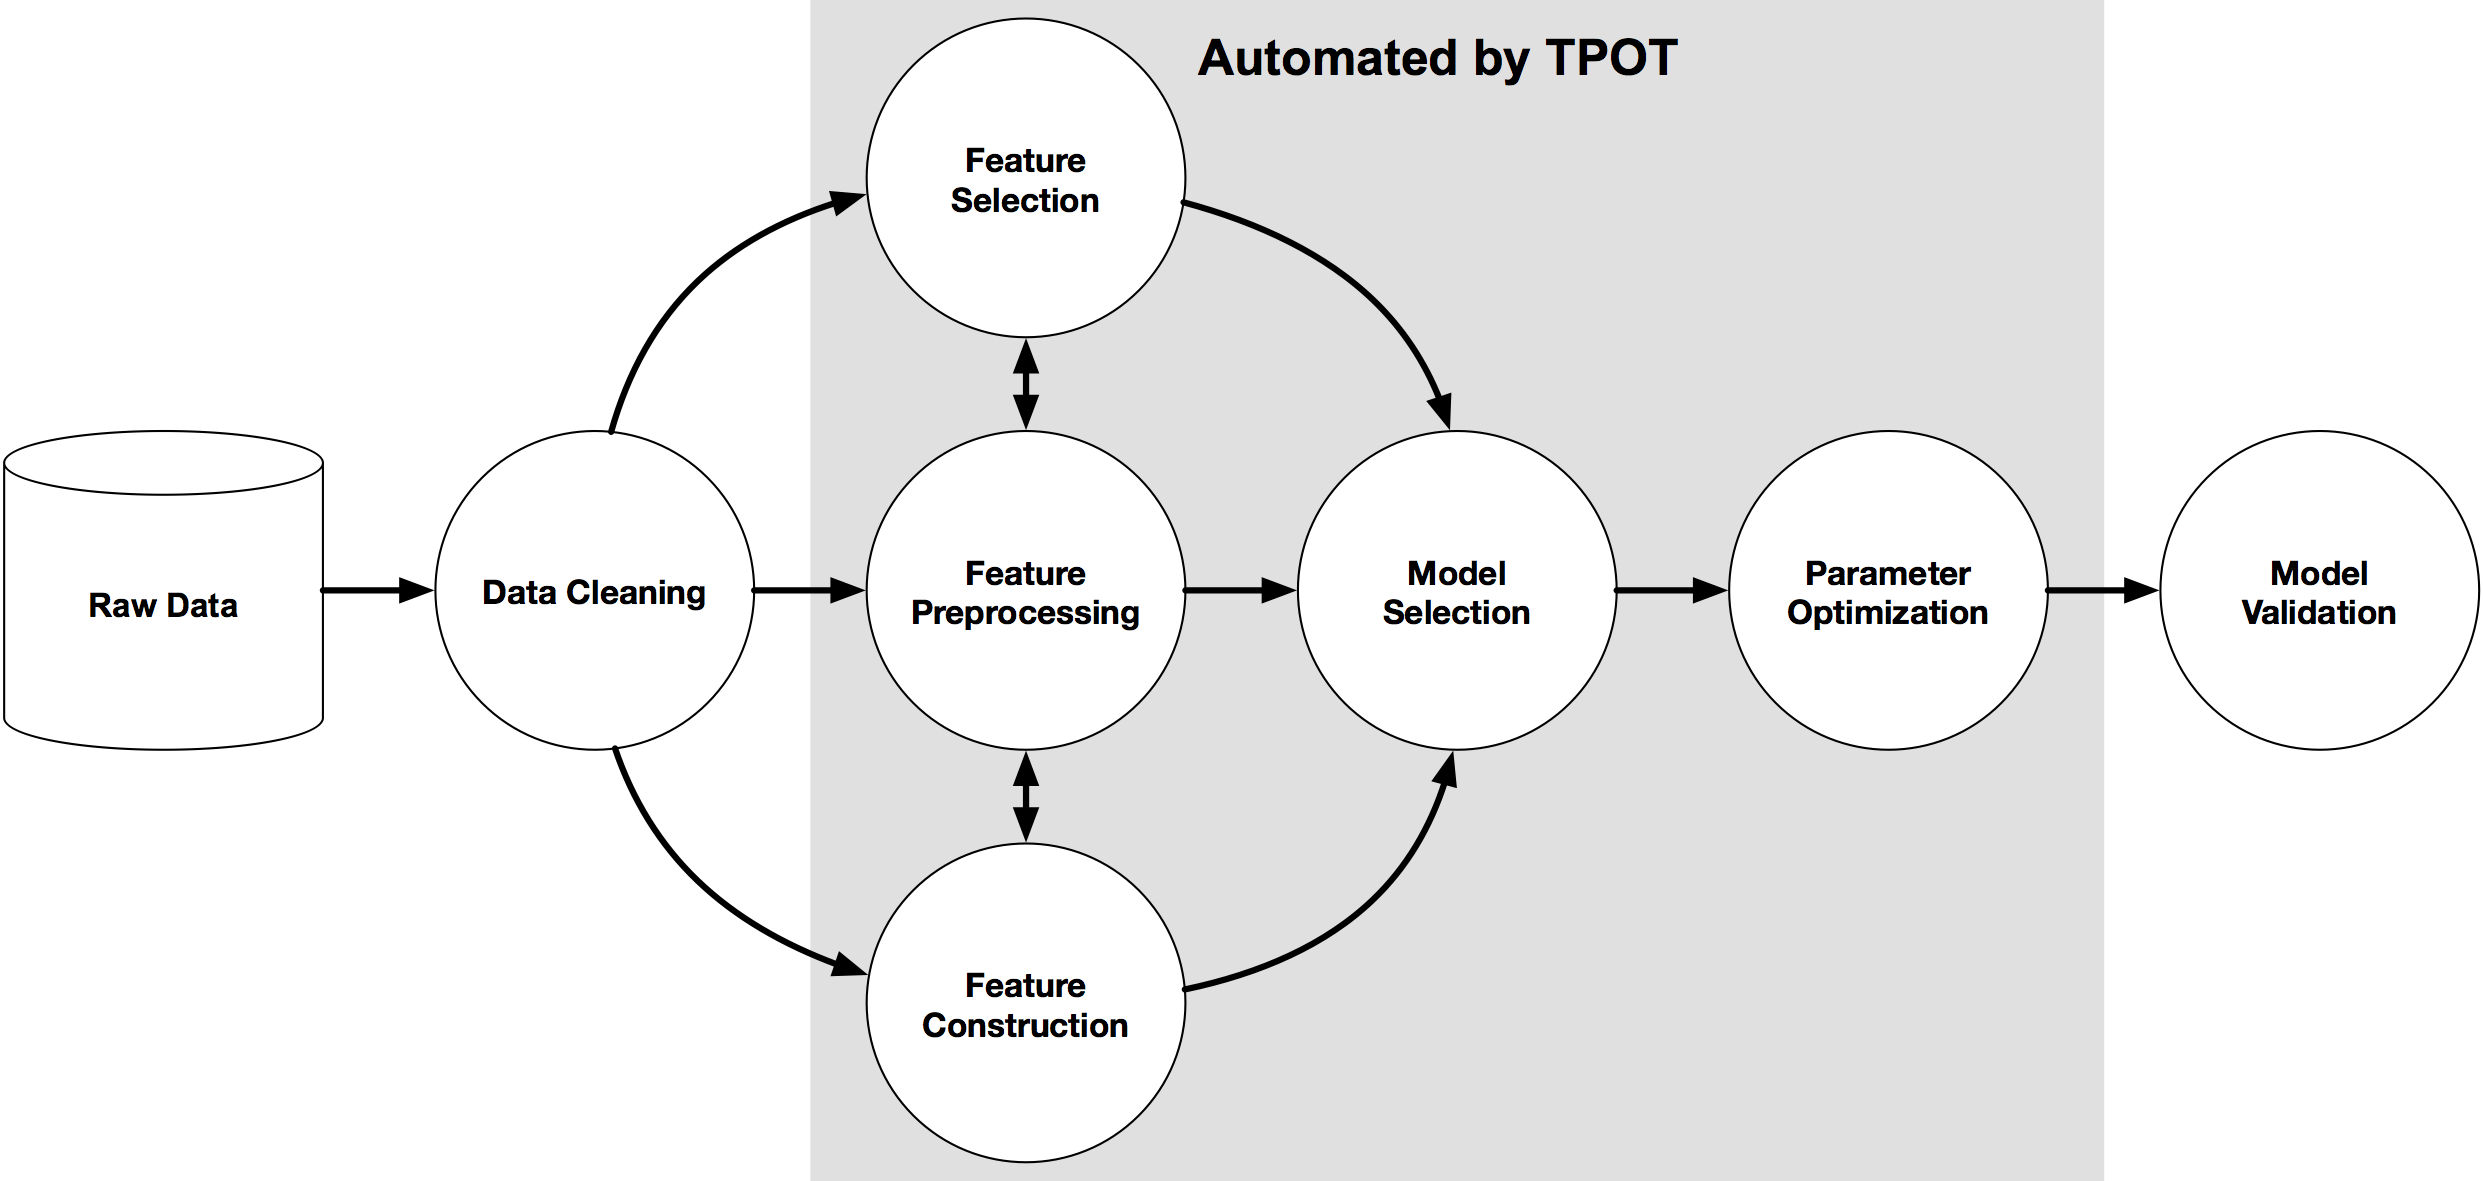

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data.features, data.target, train_size=0.75, test_size=0.25, random_state=42)

tpot = TPOTRegressor(generations=5, population_size=50, verbosity=2, random_state=42)
tpot.fit(X_train, y_train)

print(tpot.score(X_test, y_test))
tpot.export('nest_challenge.py')

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -1.3294661225319888

Generation 2 - Current best internal CV score: -1.3294661225319888

Generation 3 - Current best internal CV score: -1.3294661225319888

Generation 4 - Current best internal CV score: -1.2908347120910166

Generation 5 - Current best internal CV score: -1.2276933830787216

Best pipeline: ExtraTreesRegressor(RandomForestRegressor(input_matrix, bootstrap=True, max_features=0.9500000000000001, min_samples_leaf=4, min_samples_split=19, n_estimators=100), bootstrap=False, max_features=0.7000000000000001, min_samples_leaf=11, min_samples_split=14, n_estimators=100)
-1.1858212066711953
